In [83]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import scipy as sp
import faraway.utils

plt.rcParams['figure.figsize'] = [5.0, 5.0]
plt.rcParams['figure.dpi'] = 100 

In [2]:
import faraway.datasets.seatpos
seatpos = faraway.datasets.seatpos.load()
seatpos.head()

,Age,Weight,HtShoes,Ht,Seated,Arm,Thigh,Leg,hipcenter
0,46,180,187.2,184.9,95.2,36.1,45.3,41.3,-206.300
1,31,175,167.5,165.5,83.8,32.9,36.5,35.9,-178.210
2,23,100,153.6,152.2,82.9,26.0,36.6,31.0,-71.673
3,19,185,190.3,187.4,97.3,37.4,44.1,41.0,-257.720
4,23,159,178.0,174.1,93.9,29.5,40.1,36.9,-173.230


In [3]:
print(faraway.datasets.seatpos.DESCR)


Car seat position depending driver size

Description

Car drivers like to adjust the seat position for their own comfort. Car designers would find it helpful to know where different drivers will position the seat depending on their size and age. Researchers at the HuMoSim laboratory at the University of Michigan collected data on 38 drivers.

Usage

data(seatpos)
Format

The dataset contains the following variables

Age
Age in years

Weight
Weight in lbs

HtShoes
Height in shoes in cm

Ht
Height bare foot in cm

Seated
Seated height in cm

Arm
lower arm length in cm

Thigh
Thigh length in cm

Leg
Lower leg length in cm

hipcenter
horizontal distance of the midpoint of the hips from a fixed location in the car in mm

Source

"Linear Models in R" by Julian Faraway, CRC Press, 2004



In [4]:
seatpos.shape
list(enumerate(seatpos.columns.drop("hipcenter")))

[(0, 'Age'),
 (1, 'Weight'),
 (2, 'HtShoes'),
 (3, 'Ht'),
 (4, 'Seated'),
 (5, 'Arm'),
 (6, 'Thigh'),
 (7, 'Leg')]

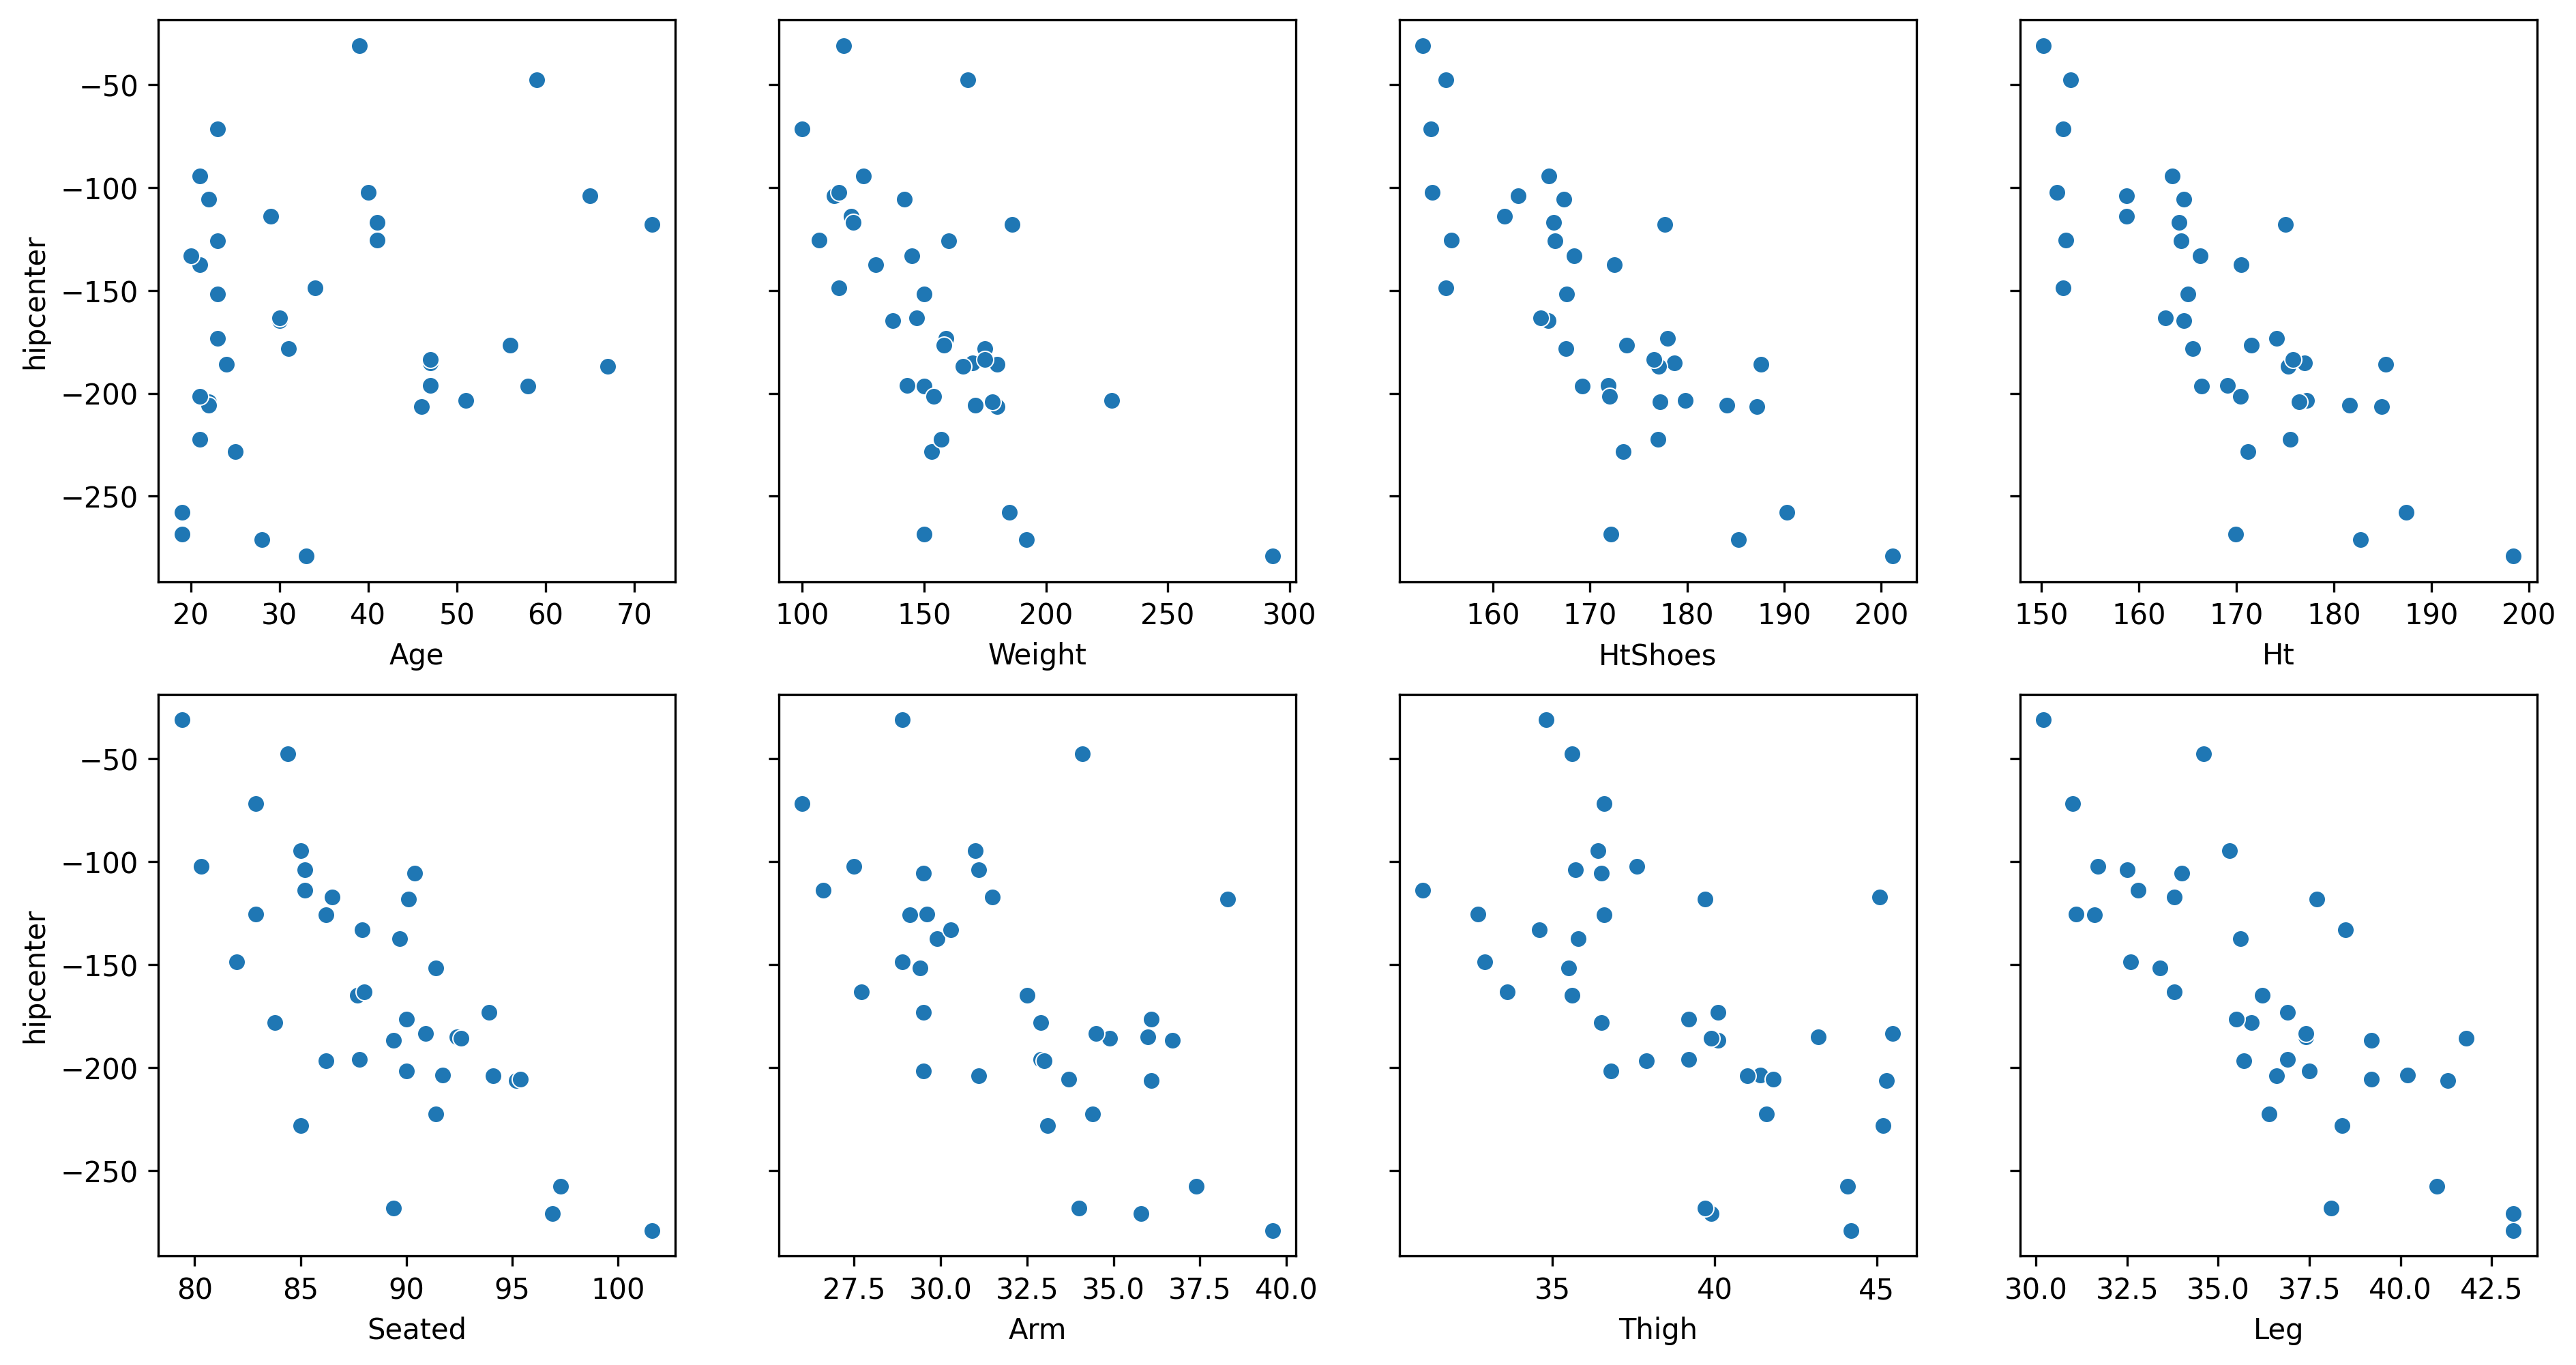

In [23]:
f, axs = plt.subplots(2, 4, sharey=True)
axs = axs.ravel()

for i, col in enumerate(seatpos.columns.drop("hipcenter")):
    sns.scatterplot(y="hipcenter", x=col, data=seatpos, ax=axs[i])

In [6]:
np.abs(seatpos.corr()["hipcenter"]).sort_values(ascending=False)

hipcenter    1.000000
Ht           0.798927
HtShoes      0.796596
Leg          0.787169
Seated       0.731254
Weight       0.640333
Thigh        0.591202
Arm          0.585095
Age          0.205172
Name: hipcenter, dtype: float64

In [7]:
seatpos[seatpos.Age < 35].corr()["hipcenter"]

Age         -0.047685
Weight      -0.718812
HtShoes     -0.772405
Ht          -0.776010
Seated      -0.677224
Arm         -0.830129
Thigh       -0.736616
Leg         -0.797624
hipcenter    1.000000
Name: hipcenter, dtype: float64

The plot `y` against `Age` suggests that there are two groups. The numerical has proved this. </br>
It would make sense to introduce a categorical variable like "young"/"old", because for the most part that's the only thing that makes a difference here. </br>
I still don't think it is a good idea, because we are still loosing some infrormation and generally do not quite achieve anything. It is just nice to keep this observation in mind.

In [8]:
import faraway.utils

lmod = smf.ols(
    "hipcenter ~ Ht + HtShoes + Seated + Arm + Thigh + Leg", 
    data=seatpos
).fit()
lmod.sumary()

            coefs  stderr tvalues pvalues
Intercept 486.643 122.034    3.99  0.0004
Ht         -3.175   9.659   -0.33  0.7446
HtShoes     0.537   9.452    0.06  0.9551
Seated      0.139   3.733    0.04  0.9706
Arm         2.057   3.089    0.67  0.5104
Thigh      -0.793   2.617   -0.30  0.7639
Leg        -7.024   4.671   -1.50  0.1428

n=38 p=7 Residual SD=37.733 R-squared=0.66


We see clear signs of multicollinearity: no predictors are significant, though the explained variance is.

In [9]:
%run utils.ipynb

In [10]:
get_cond_nums(lmod)

array([5.27677387e+03, 5.72795184e+02, 2.17968266e+02, 1.54067277e+02,
       1.20105701e+02, 8.64954936e+01, 1.00000000e+00])

In [11]:
vifs = 1/(1-get_partial_rsq(lmod))
vifs.drop("Intercept")

Ht         302.717473
HtShoes    288.575135
Seated       8.807734
Leg          6.568610
Arm          2.819449
Thigh        2.672131
dtype: float64

We see 2-3 big condition numbers; High VIFs for first 4 variables; -- we have confirmed our suspicion about multicollinearity. </br>
Now, it is intuitive that `Ht` and `HtShoes` are strongly correlated. </br>
The most straightforward way to adress the issue here is to use PCA.

<AxesSubplot:>

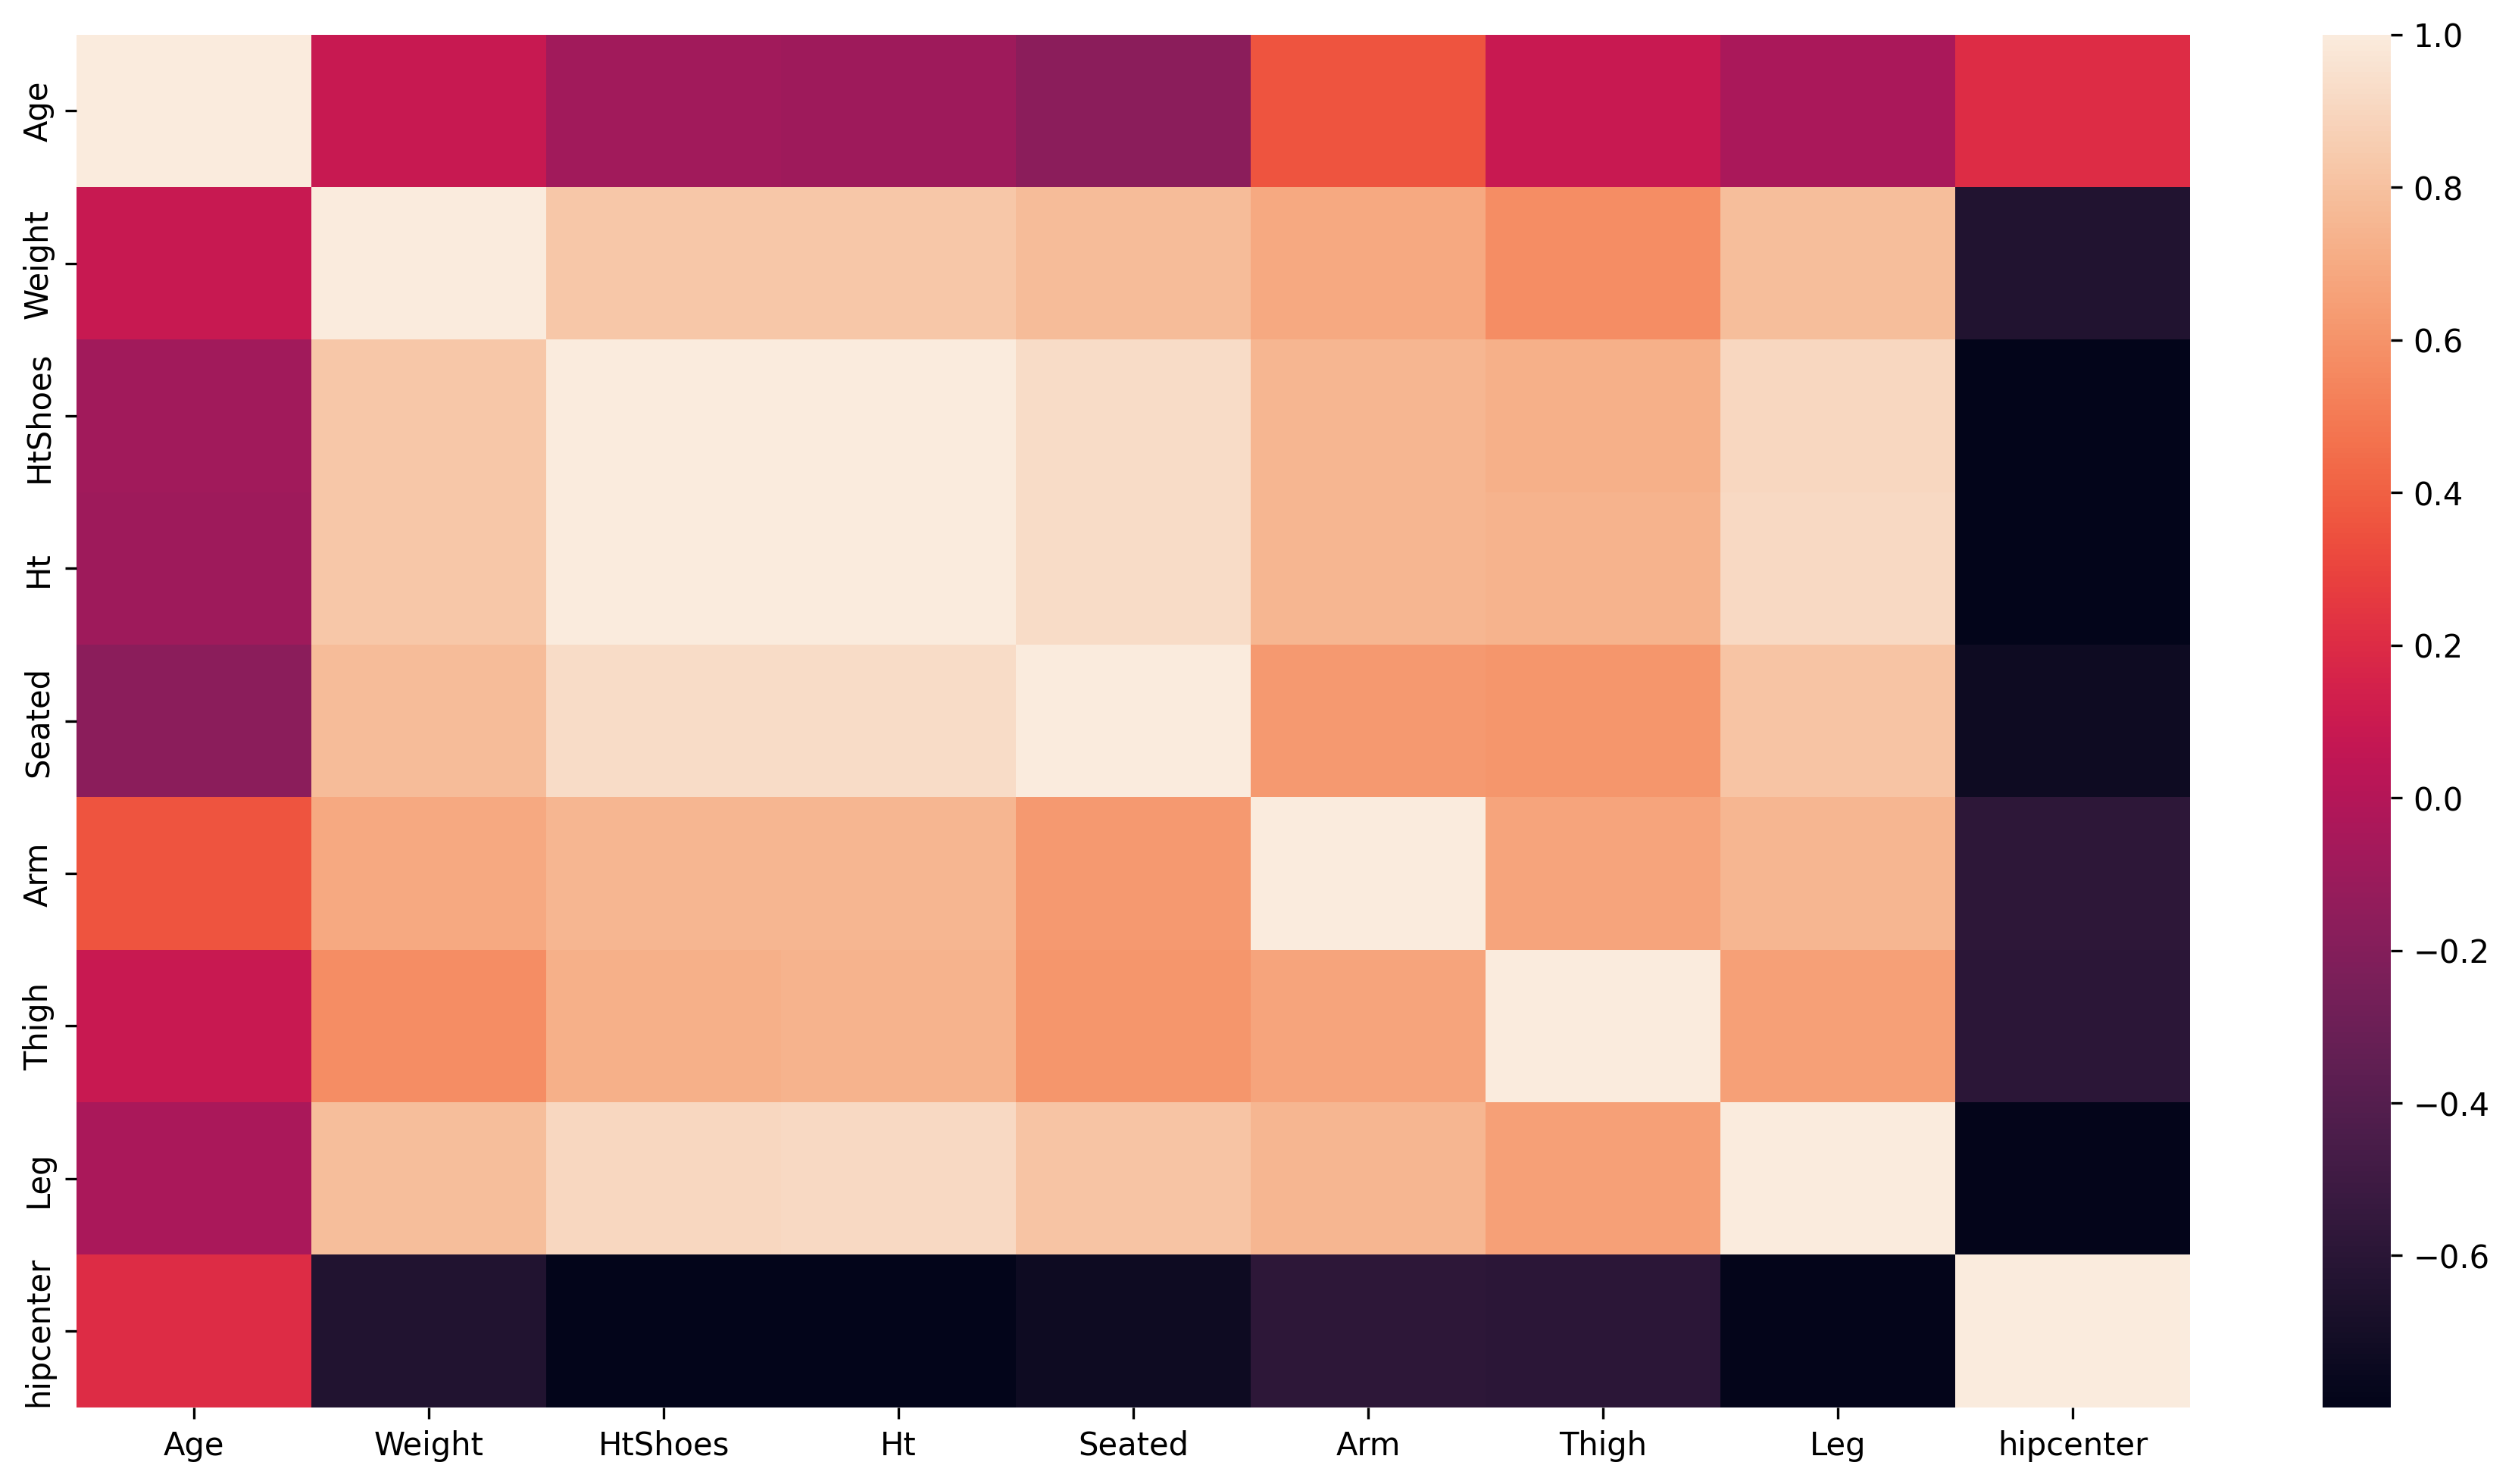

In [24]:
sns.heatmap(seatpos.corr())

All of the predictors, besides `Age`, are strongly correlated with each other. </br>
This, and the fact that performing PCA on variables of different scale would significantly harden the explanatory prospects, suggests perfoming the procedure on measurements only.

## PCA analysis

In [13]:
from sklearn.decomposition import PCA
# these are the measurements
X = seatpos[["Ht", "HtShoes", "Seated", "Leg", "Arm", "Thigh"]]
pca = PCA()
pca.fit(X)

pca.explained_variance_ratio_.round(2)

array([0.95, 0.03, 0.01, 0.01, 0.  , 0.  ])

I'll try to interpret the results

In [14]:
columns = np.core.defchararray.add(np.array(["pc"]), np.arange(1, X.shape[1]+1).astype(str))
seatpos_tr = pd.DataFrame(pca.transform(X), columns=columns)

corr = pd.concat([X, seatpos_tr], axis=1).corr().iloc[6:, 0:6].T
corr.iloc[:, :1]

,pc1
Ht,0.998938
HtShoes,0.998609
Seated,0.933063
Leg,0.913963
Arm,0.766069
Thigh,0.744992


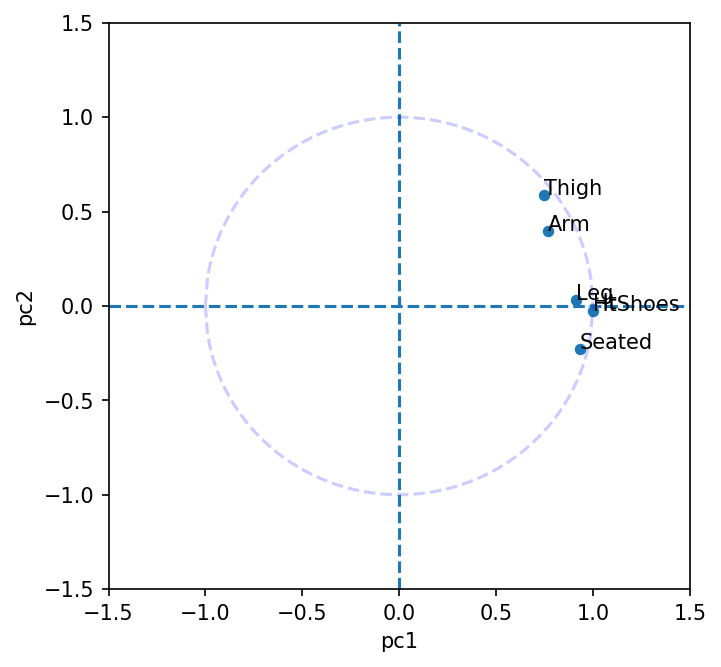

In [15]:
sns.scatterplot(x=corr.iloc[:, 0], y=corr.iloc[:, 1])

for i in range(corr.shape[0]):
    plt.text(x=corr.iloc[i, 0],y=corr.iloc[i, 1],s=corr.index[i])
    
plt.axvline(0, ls='--')
plt.axhline(0, ls='--')

ix = np.linspace(-1, 1, num=200)
plt.plot(ix, np.sqrt(1-ix**2), ls='--', color="blue", alpha=0.2)
plt.plot(ix, -np.sqrt(1-ix**2), ls="--", color="blue", alpha=0.2)

ax = plt.gca()
ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-1.5, 1.5])
# ix = np.a
plt.gcf().set_size_inches(5, 5)
plt.gcf().set_dpi(150)

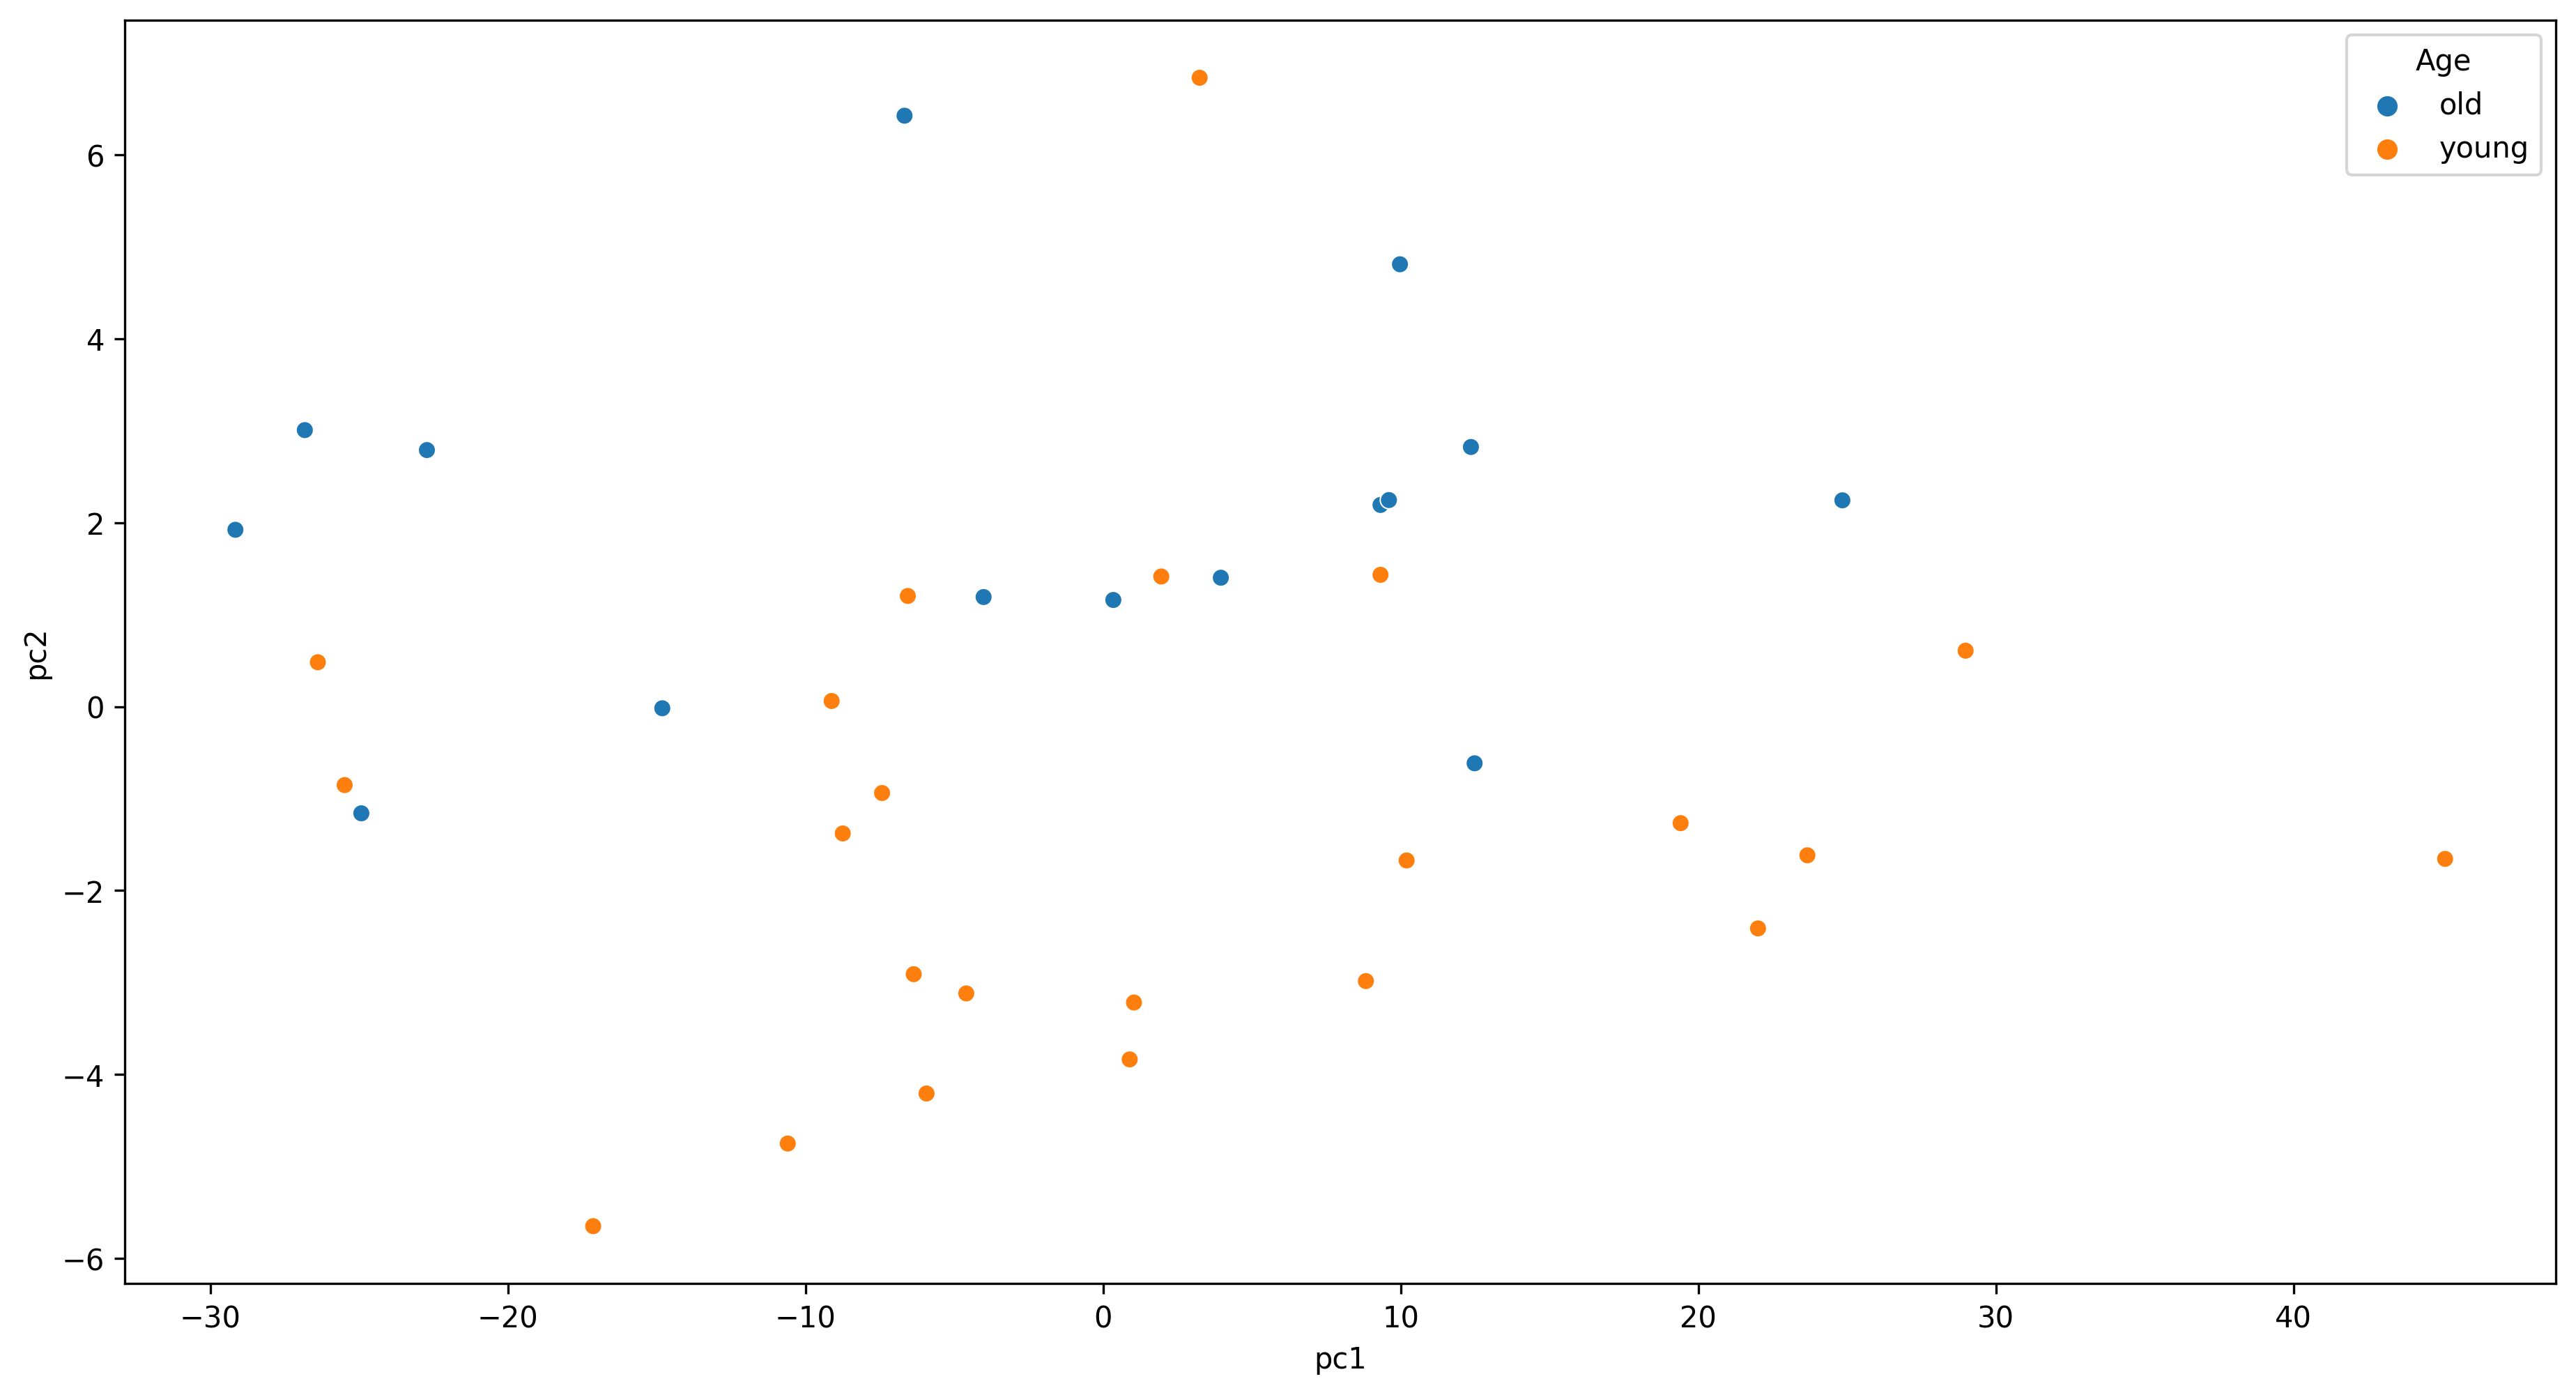

In [25]:
sns.scatterplot(
    x=seatpos_tr.iloc[:, 0], 
    y=seatpos_tr.iloc[:, 1], 
    hue=seatpos.Age.map(lambda x: "young" if x<35 else "old")
)
ax = plt.gca()

# for i in range(seatpos_tr.shape[0]):
#     plt.text(x=seatpos_tr.iloc[i, 0]+0.3,y=seatpos_tr.iloc[i, 1]+0.3,s=seatpos_tr.index[i])

The first PC might be interpreted as an average of all predictors, while the second one contrasts the age. </br>
Note that all of the variables are explained fairly well, since the points are close to the circle </br>
This is in accordance with numerical evidence: first two PCs account for the $95\%$ of the total variation. </br>

In [88]:
y = seatpos["hipcenter"]
X_pca = seatpos_tr.copy()
X_pca.insert(0, "Intercept", 1)

lmod_pca = sm.OLS(y, X_pca).fit()
lmod_pca.sumary()

             coefs stderr tvalues pvalues
Intercept -164.885  6.121  -26.94  0.0000
pc1         -2.777  0.362   -7.68  0.0000
pc2          0.135  2.141    0.06  0.9500
pc3          0.330  2.927    0.11  0.9110
pc4         -4.102  3.966   -1.03  0.3090
pc5          5.883  5.064    1.16  0.2541
pc6          2.301 13.422    0.17  0.8650

n=38 p=7 Residual SD=37.733 R-squared=0.66


In [18]:
get_cond_nums(lmod_pca)

array([37.12263725, 16.93005339, 14.00572302, 10.96927535,  8.09661515,
        5.92266429,  1.        ])

In [19]:
vifs = 1 / (1-get_partial_rsq(lmod_pca))
vifs

Intercept    1.0
pc1          1.0
pc4          1.0
pc5          1.0
pc3          1.0
pc6          1.0
pc2          1.0
dtype: float64

We've removed collinearity completely for a reasonable price of $11\%$ of explanation

In [20]:
lmod_h = smf.ols("hipcenter ~ Ht + Weight + Age", data=seatpos).fit()
lmod_h.sumary()

            coefs  stderr tvalues pvalues
Intercept 528.298 135.313    3.90  0.0004
Ht         -4.212   0.999   -4.22  0.0002
Weight      0.004   0.312    0.01  0.9891
Age         0.520   0.408    1.27  0.2116

n=38 p=4 Residual SD=36.486 R-squared=0.66


In [21]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
X = seatpos[["Ht", "HtShoes", "Seated", "Leg", "Arm", "Thigh"]]
pca = PCA()
pca.fit(scale(X))

pca.explained_variance_ratio_.round(2)

array([0.82, 0.08, 0.06, 0.03, 0.01, 0.  ])

Scaling here is appropriate bcs all of the variables are on the same measurement scale. The situation would be more complicated if we were to include `Age` or `Weight`

### 2
Now adding `Age` and `Weight` to the equation

In [32]:
X = seatpos.drop(columns="hipcenter")
X = pd.DataFrame(scale(X), columns=X.columns)
X.insert(0, "Intercept", 1)

y = seatpos.hipcenter
lmod = sm.OLS(y, X).fit()
lmod.sumary()

             coefs  stderr tvalues pvalues
Intercept -164.885   6.119  -26.95  0.0000
Age         11.764   8.649    1.36  0.1843
Weight       0.929  11.686    0.08  0.9372
HtShoes    -29.618 107.289   -0.28  0.7845
Ht           6.630 111.685    0.06  0.9531
Seated       2.597  18.307    0.14  0.8882
Arm         -4.418  12.975   -0.34  0.7359
Thigh       -4.371  10.171   -0.43  0.6706
Leg        -21.626  15.832   -1.37  0.1824

n=38 p=9 Residual SD=37.720 R-squared=0.69


Obviously, multicoll. For this reason `Ht` has got a pos coeff, while `HtShoes` a negative one.

In [37]:
from sklearn.covariance import EllipticEnvelope
ee = EllipticEnvelope()
ee.fit(X)

EllipticEnvelope()

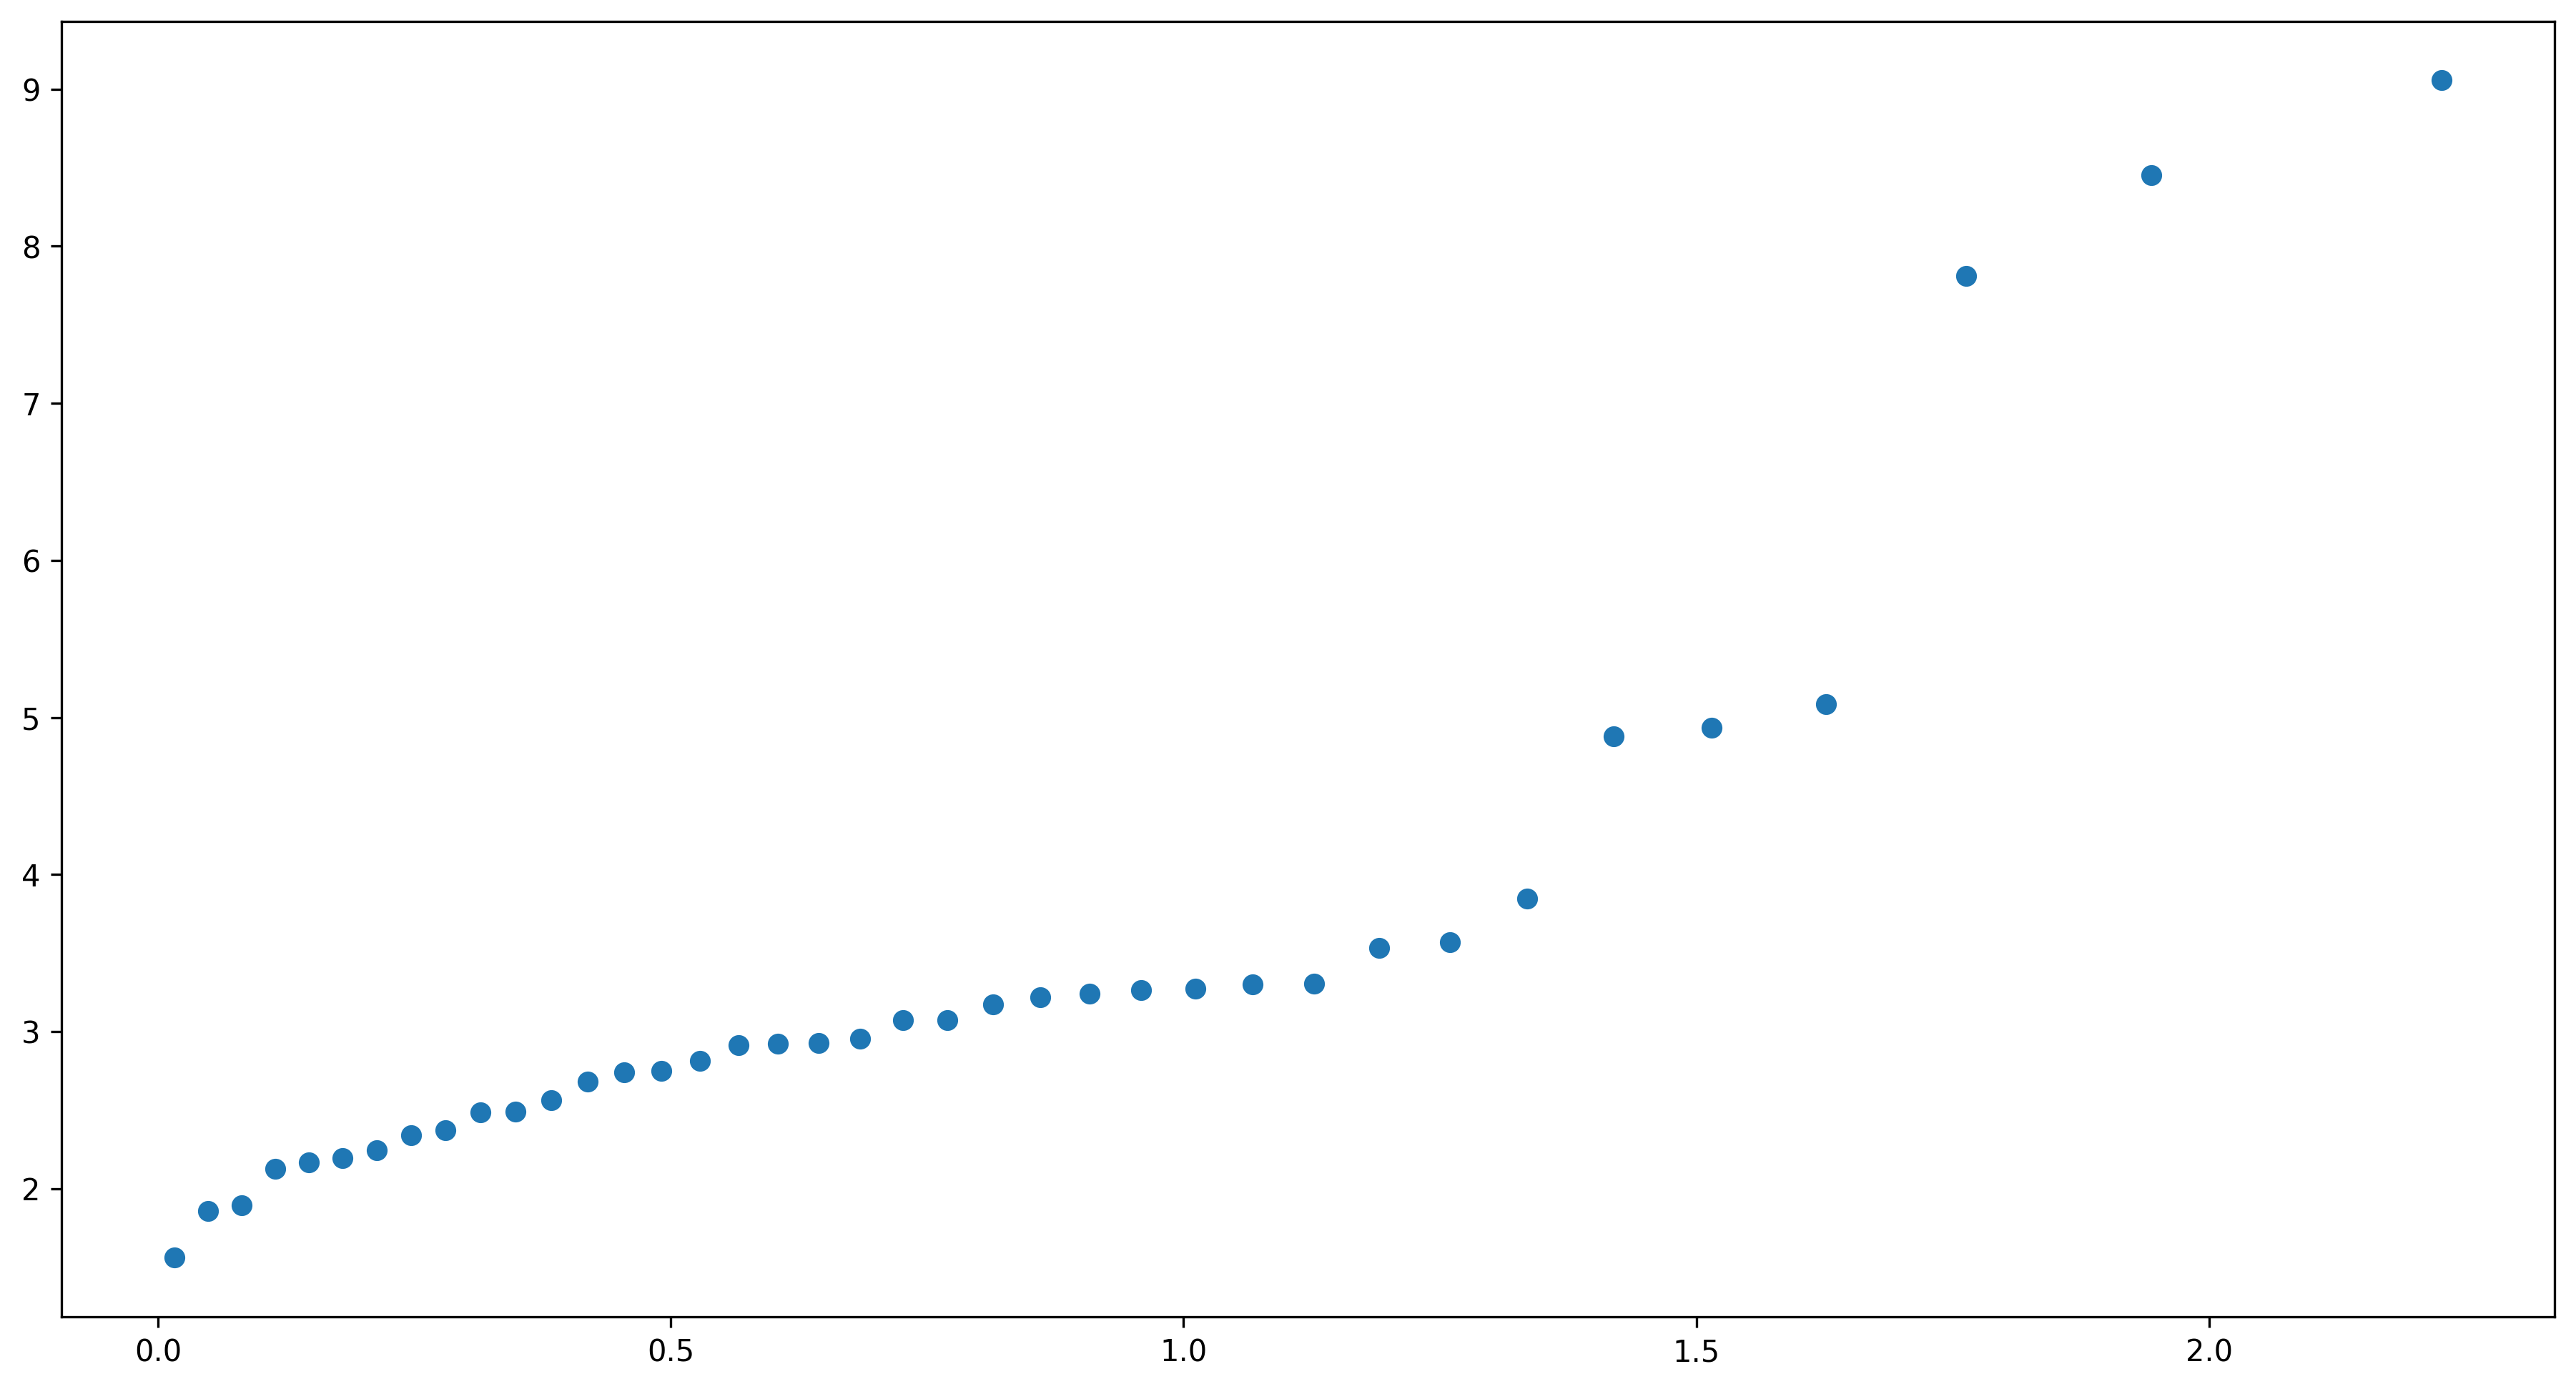

In [40]:
md = np.sqrt(ee.mahalanobis(X))
n=len(md)
ix = np.arange(1, n+1)
halfq = sp.stats.norm.ppf((n+ix)/(2*n+1))
plt.scatter(halfq, np.sort(md))

In [56]:
unusual = seatpos.iloc[np.argsort(md)[-6:]]
unusual

,Age,Weight,HtShoes,Ht,Seated,Arm,Thigh,Leg,hipcenter
27,23,160,166.4,164.3,86.2,29.1,36.6,31.6,-125.84
4,23,159,178.0,174.1,93.9,29.5,40.1,36.9,-173.23
7,28,192,185.3,182.7,96.9,35.8,39.9,43.1,-270.92
30,59,168,155.2,153.0,84.4,34.1,35.6,34.6,-47.52
12,51,227,179.8,177.2,91.7,31.1,41.4,40.2,-203.61
21,33,293,201.2,198.4,101.6,39.6,44.2,43.1,-279.15


In [55]:
seatpos.describe()

,Age,Weight,HtShoes,Ht,Seated,Arm,Thigh,Leg,hipcenter
count,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000
mean,35.263158,155.631579,171.389474,169.084211,88.952632,32.215789,38.655263,36.263158,-164.884868
std,15.368772,35.781183,11.148259,11.173316,4.931791,3.371464,3.874985,3.403688,59.647385
min,19.000000,100.000000,152.800000,150.200000,79.400000,26.000000,31.000000,30.200000,-279.150000
25%,22.250000,131.750000,165.725000,163.575000,85.200000,29.500000,35.725000,33.800000,-203.085000
50%,30.000000,153.500000,171.950000,169.500000,89.400000,32.000000,38.550000,36.300000,-174.840000
75%,46.750000,174.000000,177.575000,175.725000,91.625000,34.475000,41.300000,38.325000,-119.925000
max,72.000000,293.000000,201.200000,198.400000,101.600000,39.600000,45.500000,43.100000,-30.950000


21 record is certainly an unusual observation.

In [68]:
lmod_h.predict(pd.DataFrame(s, columns=unusual.columns, index=unusual.index))

27   -151.086333
4    -192.367271
7    -225.851200
30    -84.755496
12   -190.587656
21   -288.949246
dtype: float64

In [69]:
lmod_h.predict(pd.DataFrame(seatpos, columns=seatpos.columns,))

0    -225.817566
1    -151.920526
2    -100.378526
3    -250.352584
4    -192.367271
5    -192.066720
6    -148.811602
7    -225.851200
8    -154.077374
9    -124.553469
10   -158.907980
11    -92.261129
12   -190.587656
13   -140.766276
14   -202.493014
15   -174.533483
16   -179.139363
17   -105.881217
18   -152.946281
19   -178.367272
20   -161.132715
21   -288.949246
22   -238.931417
23    -83.570049
24   -141.791398
25   -224.424814
26   -148.484101
27   -151.086333
28   -199.311488
29    -88.955753
30    -84.755496
31   -186.991081
32   -170.586978
33    -94.599921
34   -176.793724
35   -141.059436
36   -177.843585
37   -164.276955
dtype: float64

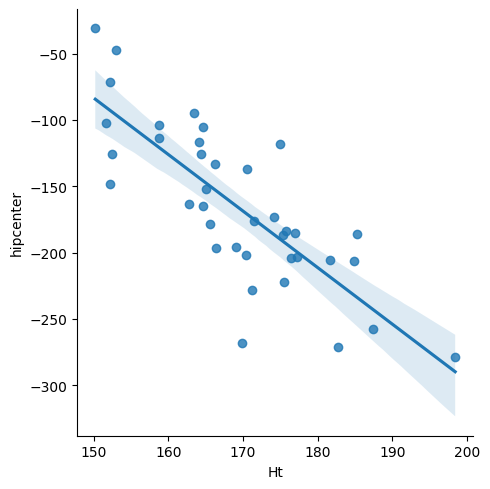

In [84]:
sns.lmplot(x="Ht", y="hipcenter", data=seatpos)

In [93]:
pd.DataFrame({
    "pca": lmod_pca.predict(X_pca),
    "regular": lmod_h.predict(pd.DataFrame(seatpos, columns=seatpos.columns,)),
})

,pca,regular
0,-238.397127,-225.817566
1,-150.640828,-151.920526
2,-95.862846,-100.378526
3,-238.645393,-250.352584
4,-187.779603,-192.367271
5,-189.416546,-192.066720
6,-150.425518,-148.811602
7,-241.174389,-225.851200
8,-136.794509,-154.077374
9,-119.066346,-124.553469
